### **Facial Keypoint Detections - Kaggle challenge**
The code is divided into n parts.
- Loading Data from Kaggle API
- Data Preparation
- Visualization
- Data Augmentation

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os
import random

#### **Loading Data from Kaggle into notebook** (one time execution)


In [ ]:
! pip install kaggle
!mkdir -p ~/.kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashnejad","key":"249dcaf84b862004c36c1fb1ff6dd01a"}'}

In [4]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c facial-keypoints-detection

 31% 5.00M/16.0M [00:00<00:01, 10.8MB/s]
100% 16.0M/16.0M [00:00<00:00, 27.2MB/s]
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 182MB/s]
 55% 33.0M/60.1M [00:01<00:01, 15.8MB/s]
100% 60.1M/60.1M [00:01<00:00, 51.8MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 120MB/s]


In [6]:
# Unpacking downloaded zips
# The output must contain test.csv,  training.csv,  IdLookupTable.csv
!unzip -q training.zip -d .
!unzip -q test.zip -d .
!ls

IdLookupTable.csv  sample_data		 test.csv  training.csv
kaggle.json	   SampleSubmission.csv  test.zip  training.zip


#### **Data Preparation**


In [9]:
Train_Dir = 'training.csv'
Test_Dir = 'test.csv'
lookid_dir = 'IdLookupTable.csv'
train = pd.read_csv(Train_Dir)  
test = pd.read_csv(Test_Dir)
lookid = pd.read_csv(lookid_dir)


In [10]:
# a preview of the data
train.head(5).T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [11]:
train.shape

(7049, 31)

In [12]:
# removing the NaN data
#train = train.dropna()

# filling with mean of the cloumn   #Not working !!!
# column_means = train.mean()
# train = train.fillna(column_means)

In [13]:
train.fillna( method ='ffill', inplace = True)    #TODO

In [9]:
train.shape

(7049, 31)

The elimination of rows with NaN values have reduced our original data to less than a third. Since the data volume is vital for a Deep Learning system and  filling by mean of the corresponding columns is a time consuming process, we temporarily filled the values by the the value of the previous row.

In the following section, the train data frame is splited into two dataframes, one containing images, the other containing key-points info.


In [14]:
img_df = train.iloc[:, 30:31]     # images dataset
points_df = train.iloc[:, 0:30]   # key-points dataset
img_df.head(5)                 # logging the first five images

,Image
0,238 236 237 238 240 240 239 241 241 243 240 23...
1,219 215 204 196 204 211 212 200 180 168 178 19...
2,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,147 148 160 196 215 214 216 217 219 220 206 18...


Next, we will reform the from on string to a Matrix. In this transformation, the missing values are replcaed with the mean of the image as well.

TODO : fill the lost pixels with better value

In [15]:
imgs = []
for i in range(0,train.shape[0]):
    img = np.reshape(np.array(img_df["Image"][i].split(' '), dtype='float'), (96,96))
    imgs.append(img)

imgs = np.array(imgs)/255.

In addition to image transformation, each row of points should be conveted to a list.

In [16]:
points = points_df.values.tolist()

#### **Visualization**

Now that the images are read and transformed to the proper structure we define a function for visulizaing an image with its key-points


In [22]:
def viualizeImageWithKeyPoints(img, keypoints, axis):
  axis.imshow(img, cmap='gray')
  axis.scatter(keypoints[::2], keypoints[1::2], marker='o', s=20)   #splits to Ys and Xs and shows
  plt.show()

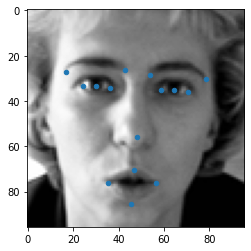

In [137]:
viualizeImageWithKeyPoints(imgs[1], points[1], plt)

#### **Data Augmentation**

In this section, we are going to use the idea which AlexNet used to produce a feature invariant to transformation. For more info, take a look at [this link](https://link.springer.com/article/10.1186/s40537-019-0197-0)

For this purpose, we transofrm each image to a 85-in-85 size and place it randomly in an area in the original in a way that contains all the key-points

In [17]:
maxCropSize = 10

In [18]:
def imageAugmentation(img, kps):
  # res_imgs=[]
  res_pnts=np.empty((1,30))
  res_imgs=np.empty((1,96-(2*maxCropSize),96-(2*maxCropSize)))
  for i in range(4):
    x_tr = random.randint(-maxCropSize,maxCropSize)
    y_tr = random.randint(-maxCropSize,maxCropSize)
    im = img[maxCropSize+int(y_tr/2):(96-(maxCropSize-int(y_tr/2))),
             maxCropSize+int(x_tr/2):(96-(maxCropSize-int(x_tr/2)))]# value of crop from left, top, right, bottom respectivley


    # calculate the new position of the key-points
    y_tr=int(maxCropSize) + int(y_tr/2)
    x_tr=int(maxCropSize) + int(x_tr/2)
    pnts_tr = kps - np.array([x_tr,y_tr,x_tr,y_tr,x_tr,y_tr,x_tr,y_tr,
                              x_tr,y_tr,x_tr,y_tr,x_tr,y_tr,x_tr,y_tr,
                              x_tr,y_tr,x_tr,y_tr,x_tr,y_tr,x_tr,y_tr,
                              x_tr,y_tr,x_tr,y_tr,x_tr,y_tr])
    res_imgs=np.concatenate((res_imgs , im.reshape(1, 96-(2*maxCropSize),96-(2*maxCropSize)))) 
    res_pnts=np.concatenate((res_pnts , pnts_tr.reshape(1,30))) 
    # viualizeImageWithKeyPoints(im, pnts_tr, plt)
  res_imgs = np.delete(res_imgs, 0, 0)          # TODO find a better conc method
  res_pnts = np.delete(res_pnts, 0, 0)
  return res_imgs, res_pnts

Creating the final augmented images dataset


In [19]:
# for i in range(imfs):
#   imageAugmentation(imgs[i],points[i])
a,b = imageAugmentation(imgs[1],points[1])
b.shape

(4, 30)

In [20]:
finalImgs = np.empty((1,96-(2*maxCropSize),96-(2*maxCropSize)))
finalPnts = np.empty((1,30))
#imgs.shape[0]
for i in range(4):
  ims, pnts = imageAugmentation(imgs[i],points[i])
  finalImgs=np.concatenate((finalImgs , ims))
  finalPnts=np.concatenate((finalPnts , pnts))

finalImgs = np.delete(finalImgs, 0, 0)          # TODO find a better conc method
finalPnts = np.delete(finalPnts, 0, 0)


augmented
augmented
augmented
augmented


In [27]:
# for i in range(16):
#   viualizeImageWithKeyPoints(finalImgs[i], finalPnts[i], plt)

finalImgs.shape

(16, 76, 76)